In [98]:
import pandas as pd
import seaborn as sns

# Data Ingestion

In [2]:
!ls data

testdemographics.csv  testprevloans.csv      trainperf.csv
testperf.csv	      traindemographics.csv  trainprevloans.csv


## Training data

### Demographics data

In [3]:
df_demo = pd.read_csv("data/traindemographics.csv").drop_duplicates()

In [4]:
df_demo.columns

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients'],
      dtype='object')

In [5]:
print(df_demo.shape)
print(df_demo.customerid.nunique())

(4334, 9)
4334


In [6]:
df_demo.isnull().sum()

customerid                       0
birthdate                        0
bank_account_type                0
longitude_gps                    0
latitude_gps                     0
bank_name_clients                0
bank_branch_clients           4283
employment_status_clients      648
level_of_education_clients    3748
dtype: int64

In [7]:
df_demo.dtypes

customerid                     object
birthdate                      object
bank_account_type              object
longitude_gps                 float64
latitude_gps                  float64
bank_name_clients              object
bank_branch_clients            object
employment_status_clients      object
level_of_education_clients     object
dtype: object

- Change 'birthdate' data type of date
- Drop 'bank_branch_clients' and 'level_of_education_clients' columns, they contain more than 50% missing values
- Replace the null values in 'employment_status_clients' with string 'UNKNOWN'

In [8]:
df_demo['birthdate'] = pd.to_datetime(df_demo['birthdate']).dt.date
df_demo = df_demo.drop(columns=['bank_branch_clients', 'level_of_education_clients'])
df_demo["employment_status_clients"].fillna("UNKNOWN", inplace = True)

In [9]:
df_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,UNKNOWN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,Permanent
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,UNKNOWN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.362850,6.642485,GT Bank,Permanent
4,8a858e785acd3412015acd48f4920d04,1982-11-22,Savings,8.455332,11.971410,GT Bank,Permanent


### Previous Loans data

In [10]:
df_prev = pd.read_csv("data/trainprevloans.csv").drop_duplicates()

In [11]:
df_prev.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'referredby', 'firstduedate', 'firstrepaiddate'],
      dtype='object')

In [12]:
print(df_prev.shape)
print(df_prev.customerid.nunique())

(18183, 12)
4359


In [13]:
df_prev.isnull().sum()

customerid             0
systemloanid           0
loannumber             0
approveddate           0
creationdate           0
loanamount             0
totaldue               0
termdays               0
closeddate             0
referredby         17157
firstduedate           0
firstrepaiddate        0
dtype: int64

In [14]:
df_prev.dtypes

customerid          object
systemloanid         int64
loannumber           int64
approveddate        object
creationdate        object
loanamount         float64
totaldue           float64
termdays             int64
closeddate          object
referredby          object
firstduedate        object
firstrepaiddate     object
dtype: object

- Drop 'referredby' columns, it contains mostly null values
- Change data type of 'approveddate','creationdate', 'closeddate', 'firstduedate', 'firstrepaiddate' to date 

In [15]:
df_prev = df_prev.drop(columns=['referredby'])
df_prev['approveddate'] = pd.to_datetime(df_prev['approveddate']).dt.date
df_prev['creationdate'] = pd.to_datetime(df_prev['creationdate']).dt.date
df_prev['closeddate'] = pd.to_datetime(df_prev['closeddate']).dt.date
df_prev['firstduedate'] = pd.to_datetime(df_prev['firstduedate']).dt.date
df_prev['firstrepaiddate'] = pd.to_datetime(df_prev['firstrepaiddate']).dt.date

### Performance data

In [16]:
df_perf = pd.read_csv("data/trainperf.csv").drop_duplicates()

In [17]:
df_perf.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby',
       'good_bad_flag'],
      dtype='object')

In [18]:
print(df_perf.shape)
print(df_perf.customerid.nunique())

(4368, 10)
4368


In [19]:
df_perf.isnull().sum()

customerid          0
systemloanid        0
loannumber          0
approveddate        0
creationdate        0
loanamount          0
totaldue            0
termdays            0
referredby       3781
good_bad_flag       0
dtype: int64

In [20]:
df_perf.dtypes

customerid        object
systemloanid       int64
loannumber         int64
approveddate      object
creationdate      object
loanamount       float64
totaldue         float64
termdays           int64
referredby        object
good_bad_flag     object
dtype: object

- Drop 'referredby' columns, it contains mostly null values
- Change data type of 'approveddate','creationdate' to date 
- Encode 'good_bad_flag' to binary

In [21]:
df_perf = df_perf.drop(columns=['referredby'])
df_perf['approveddate'] = pd.to_datetime(df_perf['approveddate']).dt.date
df_perf['creationdate'] = pd.to_datetime(df_perf['creationdate']).dt.date
df_perf["good_bad_flag"] = df_perf.good_bad_flag.map({"Good": 1, "Bad": 0})

### Merge datasets

- Create 'good_bad_flag' fearure in the Previous Loans data
- For loans of 30days and below, payment on or before the end of 'termdays' is good, otherwise, bad
- For loans of 60days and more, payments before 'firstduedate' is good, otherwise, bad

In [22]:
df_prev.loc[df_prev.termdays<=30, "good_bad_flag"] = ((df_prev.closeddate - df_prev.approveddate)<=
                                                      pd.to_timedelta(df_prev['termdays'], unit='D')).astype(int)
df_prev.loc[df_prev.termdays>30, "good_bad_flag"] = (df_prev.firstrepaiddate <= df_prev.firstduedate).astype(int)

In [23]:
# Drop 'closeddate', 'firstduedate', 'firstrepaiddate' from Previous Loans data for merge
df_prev = df_prev.drop(columns=['closeddate', 'firstduedate', 'firstrepaiddate'])

In [24]:
# Add a variable to distinguish repeat loans
df_perf["repeat"] = 1
df_prev["repeat"] = 0

In [25]:
df_loans = pd.concat([df_perf, df_prev])
df_train = pd.merge(df_loans,df_demo, on="customerid", how='left')

In [26]:
df_train = df_train.drop(columns=['approveddate', 'creationdate'])

## Test data

In [27]:
test_demo = pd.read_csv("data/testdemographics.csv").drop_duplicates()
test_prev = pd.read_csv("data/testprevloans.csv").drop_duplicates()
test_perf = pd.read_csv("data/testperf.csv").drop_duplicates()

In [28]:
test_demo.columns

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients'],
      dtype='object')

In [29]:
test_demo['birthdate'] = pd.to_datetime(test_demo['birthdate']).dt.date
test_demo = test_demo.drop(columns=['bank_branch_clients', 'level_of_education_clients'])
test_demo["employment_status_clients"].fillna("UNKNOWN", inplace = True)

In [30]:
test_prev.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'referredby', 'firstduedate', 'firstrepaiddate'],
      dtype='object')

In [31]:
test_prev = test_prev.drop(columns=['referredby'])
test_prev['approveddate'] = pd.to_datetime(test_prev['approveddate']).dt.date
test_prev['creationdate'] = pd.to_datetime(test_prev['creationdate']).dt.date
test_prev['closeddate'] = pd.to_datetime(test_prev['closeddate']).dt.date
test_prev['firstduedate'] = pd.to_datetime(test_prev['firstduedate']).dt.date
test_prev['firstrepaiddate'] = pd.to_datetime(test_prev['firstrepaiddate']).dt.date


In [32]:
test_prev.loc[test_prev.termdays<=30, "good_bad_flag"] = ((test_prev.closeddate - test_prev.approveddate)<=
                                                      pd.to_timedelta(test_prev['termdays'], unit='D')).astype(int)
test_prev.loc[test_prev.termdays>30, "good_bad_flag"] = (test_prev.firstrepaiddate <= test_prev.firstduedate).astype(int)

In [33]:
y_true = test_prev['good_bad_flag']

In [34]:
# Drop 'closeddate', 'firstduedate', 'firstrepaiddate' from Previous Loans data for merge
test_prev = test_prev.drop(columns=['approveddate', 'creationdate', 'closeddate', 
                                    'firstduedate', 'firstrepaiddate', 'good_bad_flag'])

In [35]:
test_perf.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby'],
      dtype='object')

In [36]:
test_perf = test_perf.drop(columns=['referredby','approveddate','creationdate'])

In [37]:
# Add a variable to distinguish repeat loans
test_perf["repeat"] = 1
test_prev["repeat"] = 0

In [38]:
test_loans = pd.concat([test_perf, test_prev])
df_test = pd.merge(test_loans,test_demo, on="customerid", how='left')

# Exploratory Data Analysis

In [92]:
df_train.isnull().sum()

customerid                      0
systemloanid                    0
loannumber                      0
loanamount                      0
totaldue                        0
termdays                        0
good_bad_flag                   0
repeat                          0
birthdate                    5609
bank_account_type            5609
longitude_gps                5609
latitude_gps                 5609
bank_name_clients            5609
employment_status_clients    5609
dtype: int64

- Begin by using the part of the dataset without null values.

In [93]:
use_train = df_train.dropna()
use_train["age"] = 2024 - pd.to_datetime(use_train['birthdate']).dt.year

/tmp/ipykernel_147083/3739183169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_train["age"] = 2024 - pd.to_datetime(use_train['birthdate']).dt.year


In [94]:
columns = ["loannumber","loanamount","totaldue","termdays","repeat","age","bank_account_type",
           "longitude_gps","latitude_gps","bank_name_clients","employment_status_clients", "good_bad_flag"]

In [95]:
use_train = use_train[columns]
use_train.dtypes

loannumber                     int64
loanamount                   float64
totaldue                     float64
termdays                       int64
repeat                         int64
age                            int32
bank_account_type             object
longitude_gps                float64
latitude_gps                 float64
bank_name_clients             object
employment_status_clients     object
good_bad_flag                float64
dtype: object

In [97]:
corr = use_train.select_dtypes(include="number").corr()

<Axes: >

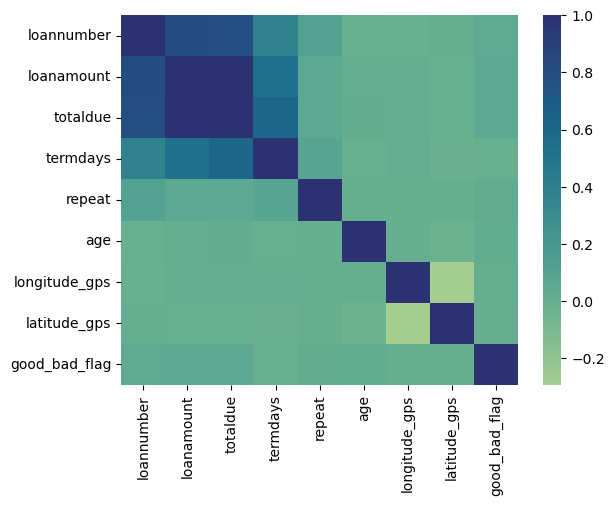

In [101]:
sns.heatmap(corr, cmap="crest")

- Totaldue and loanamount are almost perfectly correlated, i.e, redundancy.
- Drop loanamount

In [103]:
use_train = use_train.drop(columns="loanamount")

- plot scatter plot of numerical features to target variable

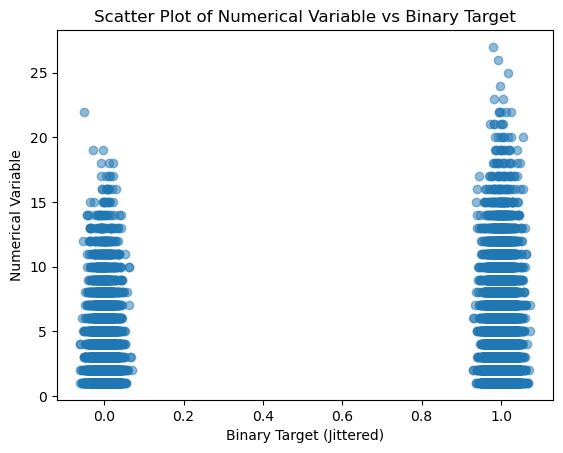

In [107]:
import numpy as np
import matplotlib.pyplot as plt
# Jitter the binary target for better visibility
jittered_target = use_train['good_bad_flag'] + np.random.normal(0, 0.02, size=len(use_train))
plt.scatter(jittered_target, use_train['loannumber'], alpha=0.5)
plt.xlabel("Binary Target (Jittered)")
plt.ylabel("Numerical Variable")
plt.title("Scatter Plot of Numerical Variable vs Binary Target")
plt.show()


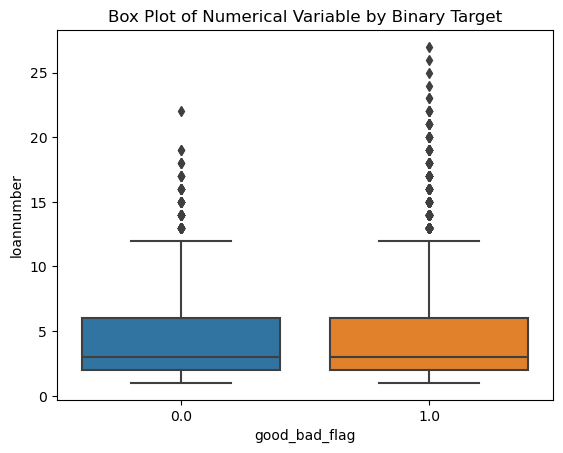

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='good_bad_flag', y='loannumber', data=use_train)
plt.title("Box Plot of Numerical Variable by Binary Target")
plt.show()

In [83]:
df_train.employment_status_clients.value_counts()

employment_status_clients
Permanent        11458
Self-Employed     2596
UNKNOWN           1856
Student            726
Unemployed         262
Retired             33
Contract            11
Name: count, dtype: int64

- plot the target variable

### To-do
- Extract age from birthdate and drop it
- Fill in missing age with nearest neighbour method
- Add UNKNOWN category for object types
- Encode missing lat and long with 0.